INFO:AI_ETL:AI Decision: Extracting from CSV source: /content/titanic.csv
INFO:AI_ETL:AI Decision: Data loaded successfully


Validation passed: No missing values.
Data cleaning complete!


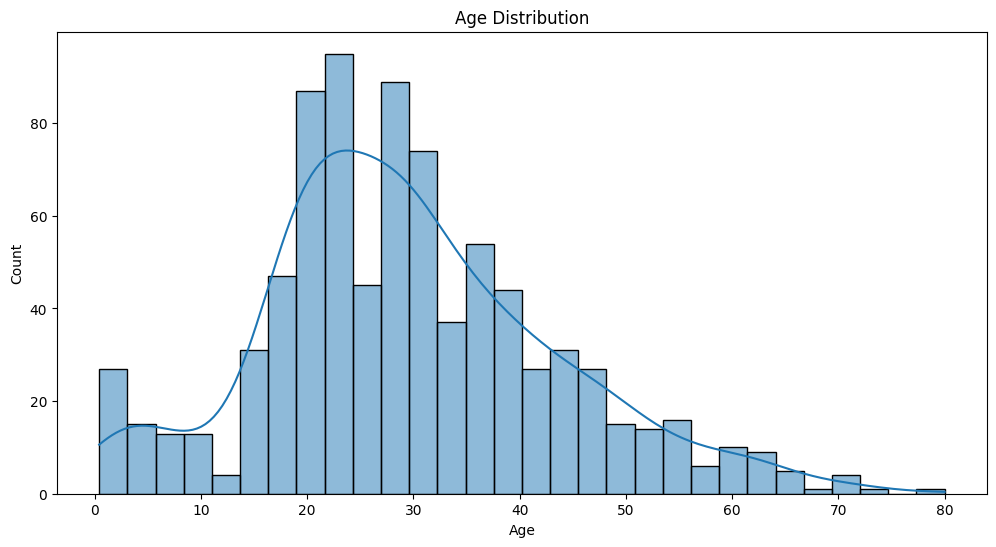

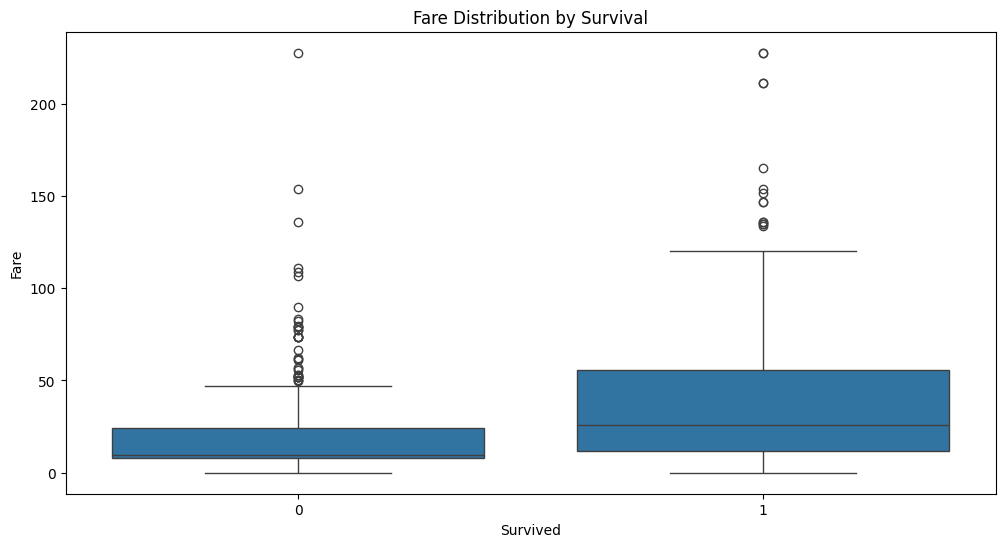

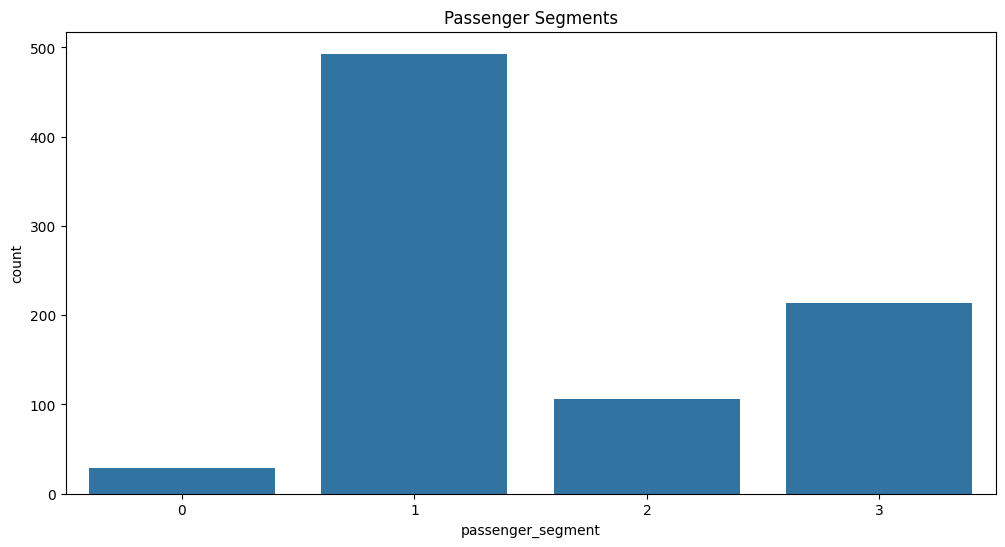

INFO:AI_ETL:AI Decision: AI Dashboard Generated


Pipeline execution completed!


In [2]:
!pip install pandas scikit-learn sqlalchemy autogluon optuna shap dask matplotlib seaborn -q

import pandas as pd
import numpy as np
import sqlite3
import logging
import yaml
import optuna
import shap
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from autogluon.tabular import TabularPredictor

# ----------------------
# AI Configuration
# ----------------------
config_content = """
ai_config:
  imputation:
    strategy: 'knn'
    n_neighbors: 5
  outlier:
    contamination: 0.05
  clustering:
    n_clusters: 4
  automl:
    time_limit: 120
    presets: 'best_quality'
"""

# Save config to YAML
with open('config.yaml', 'w') as f:
    f.write(config_content)

# Load Configuration
with open('config.yaml', 'r') as f:
    CONFIG = yaml.safe_load(f)['ai_config']

# ----------------------
# AI Logger
# ----------------------
class AILogger:
    def __init__(self):
        self.logger = logging.getLogger('AI_ETL')
        self.logger.setLevel(logging.INFO)
        handler = logging.FileHandler('ai_etl.log')
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)

    def log(self, message, level='info'):
        if level == 'info':
            self.logger.info(f"AI Decision: {message}")
        elif level == 'warning':
            self.logger.warning(f"AI Alert: {message}")

logger = AILogger()

# ----------------------
# Step 1: AI-Driven Data Extraction
# ----------------------
class SmartDataExtractor:
    def __init__(self):
        self.file_handlers = {
            'csv': self._handle_csv,
            'json': self._handle_json,
            'sql': self._handle_sql
        }

    def extract(self, source, source_type='csv'):
        logger.log(f"Extracting from {source_type.upper()} source: {source}")
        try:
            return self.file_handlers[source_type](source)
        except Exception as e:
            logger.log(f"Extraction Error: {str(e)}", 'warning')
            return pd.DataFrame()

    def _handle_csv(self, path):
        return pd.read_csv(path)

    def _handle_json(self, path):
        return pd.read_json(path, lines=True)

    def _handle_sql(self, path):
        conn = sqlite3.connect(path)
        df = pd.read_sql("SELECT * FROM data", conn)
        conn.close()
        return df

# ----------------------
# Step 2: AI-Optimized Data Transformation
# ----------------------
class AIDataProcessor:
    def __init__(self):
        self.config = CONFIG

    def transform(self, df):
        df = self._clean_data(df)
        df = self._enhance_data(df)
        return df

    def _clean_data(self, df):
        """ Validates, imputes missing values, and removes outliers """
        if df.isnull().values.any():
            print("Missing values detected! Performing KNN imputation...")
            imputer = KNNImputer(n_neighbors=self.config['imputation']['n_neighbors'])
            df[df.columns] = imputer.fit_transform(df)
        else:
            print("Validation passed: No missing values.")

        # Outlier detection using Isolation Forest
        clf = IsolationForest(contamination=self.config['outlier']['contamination'], random_state=42)
        df['anomaly_score'] = clf.fit_predict(df.select_dtypes(include=np.number))

        # Remove detected outliers
        df = df[df['anomaly_score'] == 1].drop(columns=['anomaly_score'])

        print("Data cleaning complete!")
        return df

    def _enhance_data(self, df):
        """ Enhances data using AI-based clustering """
        if 'Age' in df.columns and 'Fare' in df.columns:
            cluster_pipe = make_pipeline(
                RobustScaler(),
                KMeans(n_clusters=self.config['clustering']['n_clusters'], random_state=42)
            )
            df['passenger_segment'] = cluster_pipe.fit_predict(df[['Age', 'Fare']])
        else:
            logger.log("Skipping clustering: 'Age' or 'Fare' column missing", 'warning')

        return df

# ----------------------
# Step 3: AI Data Loading
# ----------------------
class AIDataLoader:
    def __init__(self):
        self.conn = sqlite3.connect('titanic_ai.db')

    def load(self, df):
        df.to_sql('titanic_pro', self.conn, if_exists='replace', index=False)
        self.conn.commit()
        logger.log("Data loaded successfully")

# ----------------------
# Step 4: AI-Powered Dashboard
# ----------------------
def ai_dashboard(df):
    """ Visualizes AI insights from the transformed dataset """
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Age'], bins=30, kde=True)
    plt.title("Age Distribution")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['Survived'], y=df['Fare'])
    plt.title("Fare Distribution by Survival")
    plt.show()

    if 'passenger_segment' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=df['passenger_segment'])
        plt.title("Passenger Segments")
        plt.show()

    logger.log("AI Dashboard Generated")

# ----------------------
# Execution Pipeline
# ----------------------
if __name__ == "__main__":
    extractor = SmartDataExtractor()
    processor = AIDataProcessor()
    loader = AIDataLoader()

    raw_data = extractor.extract("/content/titanic.csv", 'csv')

    if not raw_data.empty:
        processed_data = processor.transform(raw_data)
        loader.load(processed_data)
        ai_dashboard(processed_data)
        print("Pipeline execution completed!")
    else:
        print("No data extracted. Pipeline halted.")
